# **Modelos ARIMA y SARIMAX con Python**

In [ ]:
pip install pmdarima

In [ ]:
pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00


In [ ]:
# Librerías
# ======================================================================================

import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión pdarima: {pmdarima.__version__}")
print(f"{color}Versión statsmodels: {statsmodels.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.14.0
Versión pdarima: 2.0.4
Versión statsmodels: 0.14.4
Versión pandas: 2.2.2
Versión numpy: 1.26.4


In [ ]:
# Carga de datos desde el archivo Excel local
datos = pd.read_excel('/content/datos_economia.xlsx')
datos = datos.rename(columns={'Fecha':'date', 'Tipo de Cambio':'litters'})
# Convertir la columna date a tipo datetime
datos['date'] = pd.to_datetime(datos['date'], format='%Y-%m-%d')
# Establecer la columna date como índice
datos = datos.set_index('date')
# Ajustar la frecuencia a mensual (inicio de mes). Si tus datos no son mensuales,
# esta línea puede no ser necesaria o deberás usar la frecuencia apropiada.
datos = datos.asfreq('MS')
# Seleccionar la serie que te interese (en este ejemplo 'litters')
datos = datos['litters']
# Mostrar las primeras 4 filas para verificar
display(datos.head(4))

,litters
date,
1990-01-01,2.853056
1990-02-01,2.673974
1990-03-01,3.737223
1990-04-01,4.374457


Fechas train : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Fechas test  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


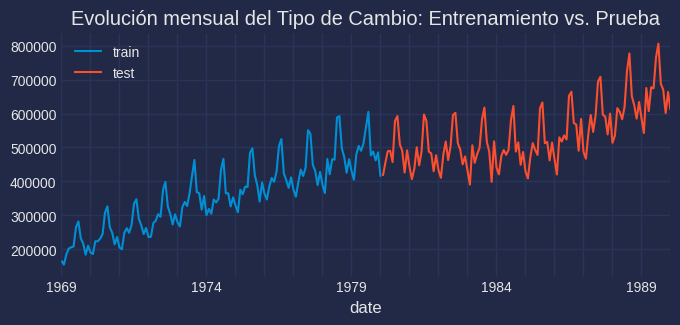

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
# Fechas Train-test
# ======================================================================================
set_dark_theme()
fin_train = '1980-01-01 23:59:59'
print(
    f"Fechas train : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas test  : {datos.loc[fin_train:].index.min()} --- {datos.loc[:].index.max()}  "
    f"(n={len(datos.loc[fin_train:])})"
)
datos_train = datos.loc[:fin_train]
datos_test  = datos.loc[fin_train:]

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.set_title('Evolución mensual del Tipo de Cambio: Entrenamiento vs. Prueba')
ax.legend();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test estacionariedad serie original
-------------------------------------
ADF Statistic: -0.44612980998227997, p-value: 0.9021071923942665
KPSS Statistic: 2.2096370946978383, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -3.641727690032331, p-value: 0.005011605002137098
KPSS Statistic: 0.313271162357279, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -8.233942641656038, p-value: 5.959599575494846e-13
KPSS Statistic: 0.08065668267482215, p-value: 0.1


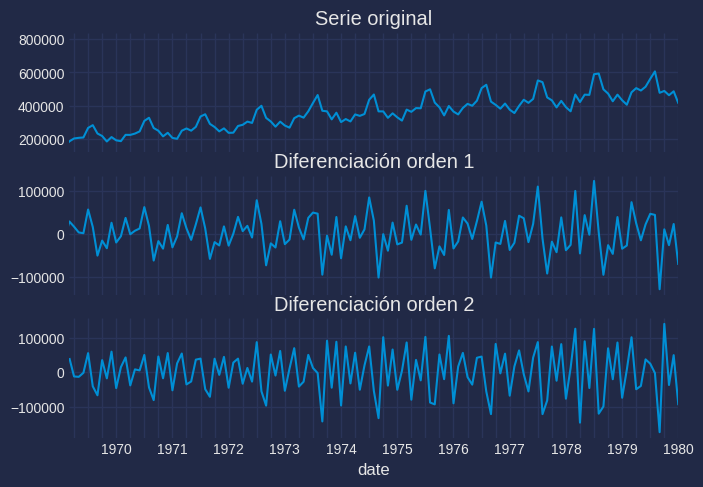

In [ ]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = datos_train.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
datos.plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


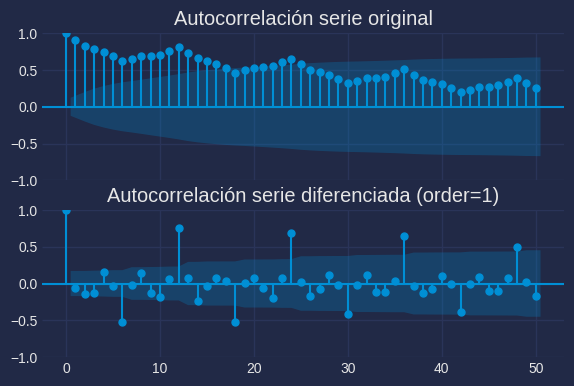

In [ ]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

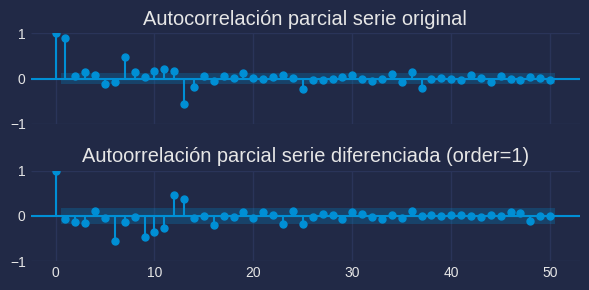

In [ ]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


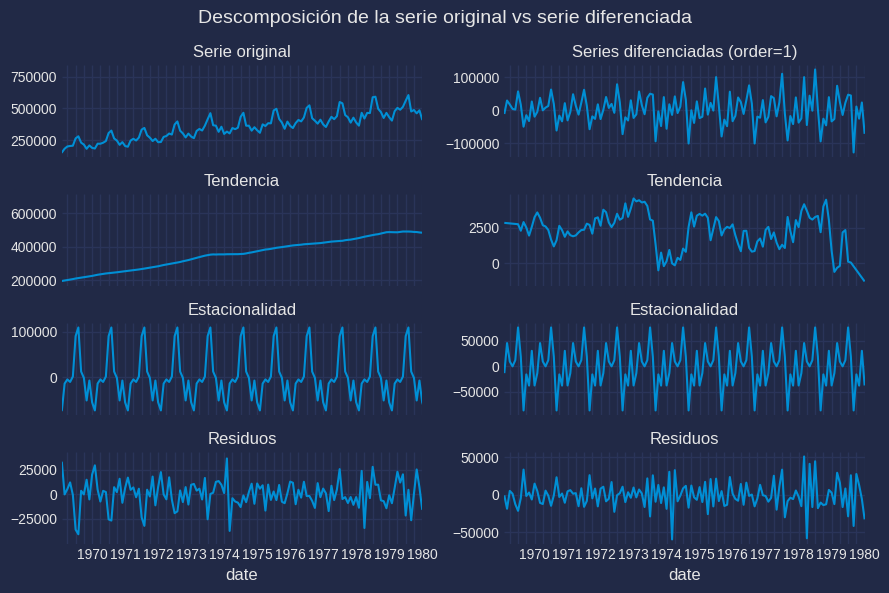

In [ ]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose = seasonal_decompose(datos, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

In [ ]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = datos_train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -4.387457230769957, p-value: 0.0003123773271126916
KPSS Statistic: 0.06291573421251052, p-value: 0.1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            litters   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1356.051
Date:                            Sun, 15 Dec 2024   AIC                           2722.103
Time:                                    02:43:17   BIC                           2736.040
Sample:                                01-01-1969   HQIC                          2727.763
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4972      0.134     -3.707      0.000      -0.760      -0.234
ma.L1         -0.0096      0.146     -0.066      0.947      -0.295       0.276
ar.S.L12       0.0465      0.162      0.288      0.774      -0.270       0.364
ma.S.L12      -0.3740      0.203     -1.847      0.065      -0.771       0.023
sigma2      3.291e+08   1.06e-09    3.1e+17      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                18.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.98e+33. Standard errors may be unstable.
"""

In [ ]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,predicciones_statsmodels
1980-02-01,407504.056923
1980-03-01,473997.245798
1980-04-01,489983.091496
1980-05-01,485517.462855


In [ ]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()
warnings.filterwarnings("default")
# Predictión
# ==============================================================================
predicciones_skforecast = modelo.predict(steps=len(datos_test))
display(predicciones_skforecast.head(4))

,pred
1980-02-01,407504.056923
1980-03-01,473997.245798
1980-04-01,489983.091496
1980-05-01,485517.462855


In [ ]:
# Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
modelo = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1355.749
Date:                            Sun, 15 Dec 2024   AIC                           2723.498
Time:                                    02:43:24   BIC                           2740.223
Sample:                                01-01-1969   HQIC                          2730.290
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -474.5820   1101.722     -0.431      0.667   -2633.917    1684.753
ar.L1         -0.4896      0.138     -3.554      0.000      -0.760      -0.220
ma.L1         -0.0211      0.151     -0.139      0.889      -0.317       0.275
ar.S.L12       0.0545      0.164      0.331      0.740      -0.268       0.377
ma.S.L12      -0.3841      0.204     -1.884      0.060      -0.784       0.015
sigma2      3.289e+08      0.002   1.84e+11      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.90   Jarque-Bera (JB):                18.55
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.43
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.73e+27. Standard errors may be unstable.
"""

In [ ]:
# Prediction
# ==============================================================================
predicciones_pdmarima = modelo.predict(len(datos_test))
predicciones_pdmarima.name = 'predicciones_pdmarima'
display(predicciones_pdmarima.head(4))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,predicciones_pdmarima
1980-02-01,406998.311377
1980-03-01,472944.444483
1980-04-01,488389.125288
1980-05-01,483432.075696


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


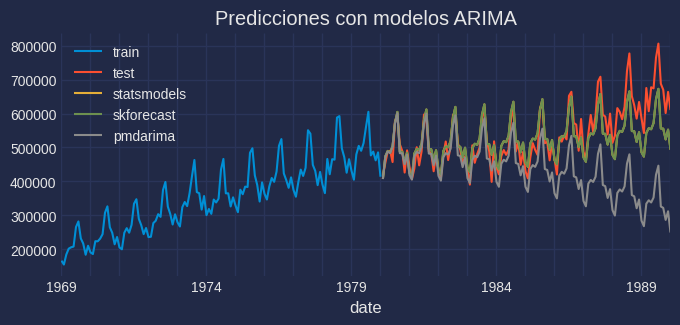

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
predicciones_skforecast.columns = ['skforecast']
predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predicciones con modelos ARIMA')
ax.legend();

In [ ]:
# Modelo ARIMA con ForecasterSarimax y skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=datos_train, suppress_warnings=True)

# Predicción
predicciones = forecaster.predict(steps=len(datos_test))
predicciones.head(4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pred
1980-02-01,407504.056923
1980-03-01,473997.245798
1980-04-01,489983.091496
1980-05-01,485517.462855


In [ ]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(datos_train),
        refit              = True,
        fixed_train_size   = False,
)
metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = datos,
                            cv                    = cv,
                            metric                = 'mean_absolute_error',
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )
display(metrica)
display(predicciones.head(4))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Information of folds
--------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=145)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=157)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02

  0%|          | 0/10 [00:00<?, ?it/s]

,mean_absolute_error
0,19611.236352


,pred
1980-02-01,407504.056923
1980-03-01,473997.245798
1980-04-01,489983.091496
1980-05-01,485517.462855


In [ ]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(datos_train),
        refit              = True,
        fixed_train_size   = False,
)
metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = datos,
                            cv                    = cv,
                            metric                = 'mean_absolute_error',
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )
display(metrica)
display(predicciones.head(4))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Information of folds
--------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=145)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=157)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02

  0%|          | 0/10 [00:00<?, ?it/s]

,mean_absolute_error
0,19611.236352


,pred
1980-02-01,407504.056923
1980-03-01,473997.245798
1980-04-01,489983.091496
1980-05-01,485517.462855


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


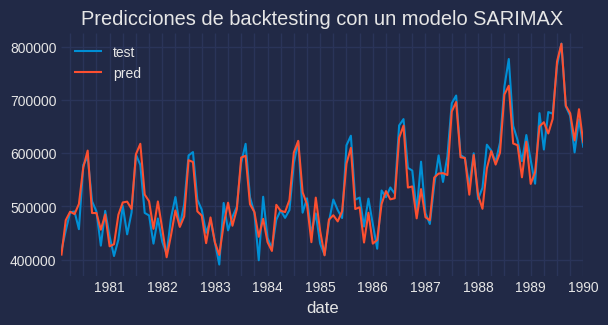

In [ ]:
# Gráfico predicciones de backtesting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_train:].plot(ax=ax, label='test')
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
ax.legend();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fechas entrenamiento : 1969-01-01 00:00:00 --- 1976-01-01 00:00:00  (n=85)
Fechas validacion    : 1976-02-01 00:00:00 --- 1984-01-01 00:00:00  (n=96)
Fechas test          : 1984-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=72)


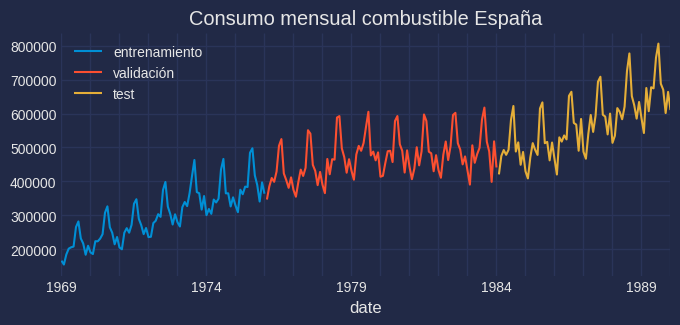

In [ ]:
# Train-validation-test
# ======================================================================================
fin_train = '1976-01-01 23:59:59'
fin_val = '1984-01-01 23:59:59'
print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {datos.loc[fin_train:].index.min()} --- {datos.loc[:fin_val].index.max()}  "
    f"(n={len(datos.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {datos.loc[fin_val:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_val:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:fin_val].plot(ax=ax, label='validación')
datos.loc[fin_val:].plot(ax=ax, label='test')
ax.set_title('Consumo mensual combustible España')
ax.legend();

In [ ]:
# Grid search basado en backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'n', 'c']
}

cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(datos_train),
        refit              = True,
        fixed_train_size   = False,
    )

resultados_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = datos.loc[:fin_val],
                   cv                    = cv,
                   param_grid            = param_grid,
                   metric                = 'mean_absolute_error',
                   return_best           = False,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )
resultados_grid.head(5)

Number of models compared: 45.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


params grid:   0%|          | 0/45 [00:00<?, ?it/s]

,params,mean_absolute_error,order,seasonal_order,trend
0,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897507,"(0, 1, 1)","(1, 1, 1, 12)",n
1,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897507,"(0, 1, 1)","(1, 1, 1, 12)",None
2,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376861,"(1, 1, 1)","(1, 1, 1, 12)",n
3,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376861,"(1, 1, 1)","(1, 1, 1, 12)",None
4,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",20176.735883,"(2, 1, 1)","(1, 1, 1, 12)",n


In [ ]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
modelo = auto_arima(
            y                 = datos.loc[:fin_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12,   # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3903.204, Time=0.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3942.897, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3846.786, Time=0.77 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3840.318, Time=0.90 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3873.797, Time=0.33 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3841.882, Time=2.10 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3841.572, Time=1.89 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3852.231, Time=0.40 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3842.593, Time=3.81 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3904.615, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3834.135, Time=0.58 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3866.187, Time=0.17 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3835.564, Time=0.60 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3835.160, Time=1.91 sec
 ARIMA(1,1,1)(1,1,0

In [ ]:
# Captura de los resultados de auto_arima en un DataFrame
# ==============================================================================
buffer = StringIO()
with contextlib.redirect_stdout(buffer):
    auto_arima(
            y                 = datos.loc[:fin_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12,  # periodicidad de la estacionalidad
            d                 = None, # el algoritmo determina 'd'
            D                 = None, # el algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
trace_autoarima = buffer.getvalue()
pattern = r"ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([\d\.]+), Time=([\d\.]+) sec"
matches = re.findall(pattern, trace_autoarima)
results = pd.DataFrame(
    matches, columns=["p", "d", "q", "P", "D", "Q", "m", "intercept", "AIC", "Time"]
)
results["order"] = results[["p", "d", "q"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]})", axis=1
)
results["seasonal_order"] = results[["P", "D", "Q", "m"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]},{x.iloc[3]})", axis=1
)
results = results[["order", "seasonal_order", "intercept", "AIC", "Time"]]
results.sort_values(by="AIC").reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,order,seasonal_order,intercept,AIC,Time
0,"(1,1,1)","(0,1,1,12)",,3834.135,0.53
1,"(2,1,0)","(0,1,1,12)",,3834.277,0.38
2,"(0,1,2)","(0,1,1,12)",,3834.320,1.28
3,"(1,1,1)","(0,1,2,12)",,3835.160,1.80
4,"(1,1,1)","(0,1,1,12)",intercept,3835.455,0.52
5,"(1,1,1)","(1,1,1,12)",,3835.564,0.57
6,"(2,1,1)","(0,1,1,12)",,3836.104,1.62
7,"(1,1,2)","(0,1,1,12)",,3836.107,2.48
8,"(1,1,1)","(1,1,2,12)",,3836.443,2.95
9,"(1,1,0)","(0,1,1,12)",,3836.696,0.30


In [ ]:
# Predicciones de backtesting con el mejor modelo según el grid search
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(datos.loc[:fin_val]),
        refit              = True,
)
metrica_m1, predicciones_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = datos,
                                cv                    = cv,
                                metric                = 'mean_absolute_error',
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                              )

# Predicciones de backtesting con el mejor modelo según auto arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), maxiter=500),
             )
metrica_m2, predicciones_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = datos,
                                cv                    = cv,
                                metric                = 'mean_absolute_error',
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                              )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,mean_absolute_error
0,19803.080711


Metric (mean_absolute_error) del modelo auto arima:


,mean_absolute_error
0,20149.352203


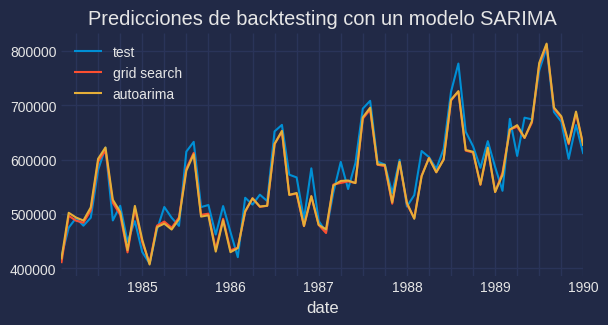

In [ ]:
# Comparación de métricas
# ==============================================================================
print("Metrica (mean absolute error) del modelo grid search:")
display(metrica_m1)
print("Metric (mean_absolute_error) del modelo auto arima:")
display(metrica_m2)

fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_val:].plot(ax=ax, label='test')
predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
predicciones_m2 = predicciones_m2.rename(columns={'pred': 'autoarima'})
predicciones_m1.plot(ax=ax)
predicciones_m2.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fechas entrenamiento : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Fechas Last window  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


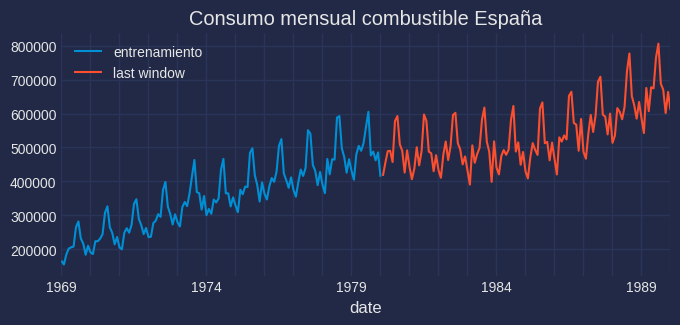

In [ ]:
# División datos Train - Last window
# ==============================================================================
fin_train = '1980-01-01 23:59:59'

print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas Last window  : {datos.loc[fin_train:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_train:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:].plot(ax=ax, label='last window')
ax.set_title('Consumo mensual combustible España')
ax.legend();

In [ ]:
# Entrenar modelo con datos desde 1969-01-01 hasta 1980-01-01
# ==============================================================================
forecaster = ForecasterSarimax(
                regressor = Sarimax(
                    order          = (0, 1, 1),
                    seasonal_order = (1, 1, 1, 12),
                    maxiter        = 500
                )
)
forecaster.fit(y=datos.loc[:fin_train])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Entrenar modelo con datos desde 1969-01-01 hasta 1980-01-01
# ==============================================================================
forecaster = ForecasterSarimax(
                regressor = Sarimax(
                    order          = (0, 1, 1),
                    seasonal_order = (1, 1, 1, 12),
                    maxiter        = 500
                )
)
forecaster.fit(y=datos.loc[:fin_train])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


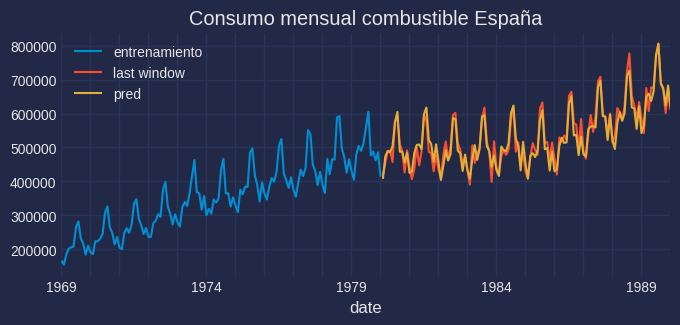

In [ ]:
# Gráfico predicciones
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:].plot(ax=ax, label='last window')
predicciones.plot(ax=ax, label='predicciones')
ax.set_title('Consumo mensual combustible España')
ax.legend();

In [ ]:
!pip install -q session-info


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.8.0
numpy               1.26.4
pandas              2.2.2
pmdarima            2.0.4
session_info        1.0.0
skforecast          0.14.0
statsmodels         0.14.4
-----
IPython             7.34.0
jupyter_client      6.1.12
jupyter_core        5.7.2
notebook            6.5.5
-----
Python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Linux-6.1.85+-x86_64-with-glibc2.35
-----
Session information updated at 2024-12-15 02:46


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


# **Bibliografía**
Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia.

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov

Python for Finance: Mastering datos-Driven Finance

Forecasting: theory and practice